In [ ]:
import os
import time

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import torch
import torch.optim as optim
#from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.optim.lr_scheduler as lr_scheduler
import timm
from sklearn.metrics import accuracy_score

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:

n_classes = 15   # ターゲットのクラス数

img_size = 224    # リサイズのサイズ

init_learning_rate = 0.0001    # 学習率（初期）
n_epochs = 2
batch_size = 64

In [ ]:
!ls tmp/cable_classify_15classes_PT

images    test.csv  train.csv


In [ ]:
df_train = pd.read_csv('tmp/cable_classify_15classes_PT/train.csv')
print(df_train.shape)
df_train.head()

(1400, 4)


,image,label_original,label,fold
0,b8dc2c14_trim.jpg,HDMI,4,6
1,0f785409_trim.jpg,USB_Type_C,2,5
2,cf3ff1a0_trim.jpg,USB_Mini,9,6
3,2f111928_trim.jpg,Dock,11,2
4,a4c6af0c_trim.jpg,USB_Micro_B,0,4


In [ ]:
df_train['label'].nunique()

15

In [ ]:
df_train['fold'].value_counts()

3    220
6    215
1    206
5    201
0    199
4    184
2    175
Name: fold, dtype: int64

In [ ]:
image_dir = 'tmp/cable_classify_15classes_PT/images'

In [ ]:
# データ拡張
transform_soft_train = A.Compose([
    A.Resize(height=img_size, width=img_size, p=1),    # リサイズ（圧縮）
    A.HorizontalFlip(p=0.5),    # 左右反転
])

transform_soft_valid = A.Compose([
    A.Resize(height=img_size, width=img_size, p=1),    # リサイズ（圧縮）
])

transform_soft_train

Compose([
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, img_dir, transforms, mode='train'):

        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_file_name = self.df.loc[index, 'image']
        img_file_path = os.path.join(self.img_dir, img_file_name)
        target = self.df.loc[index, 'label']

        image = cv2.imread(img_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        image_transformed = self.transforms(image=image)['image']

        image_transformed = image_transformed.astype(np.float32)
        image_transformed = image_transformed.transpose(2, 0, 1)
        image_transformed /= 255.

        if self.mode == 'inference':
            return torch.tensor(image_transformed).float()
        else:   # Train/Valid/Testなど正解ラベルが必要な時
            return torch.tensor(image_transformed).float(), torch.tensor(target).long()

        #return torch.tensor(image_transformed).float(), torch.tensor(target).long()

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 224, 224]) tensor(9)


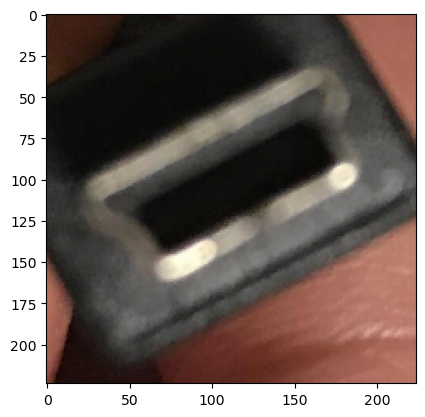

In [ ]:
# Dataset test
tmp_dataset = CustomDataset(df=df_train, img_dir=image_dir, transforms=transform_soft_train, mode='train')
print(tmp_dataset)

tmp_img, tmp_label = tmp_dataset[2]
print(type(tmp_img), type(tmp_label))
print(tmp_img.shape, tmp_label)

plt.imshow(tmp_img.permute(1, 2, 0))
plt.show()

In [ ]:
tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
print(len(tmp_loader))     #  データ数 / batch_size  ->  バッチループ数
tmp_loader

22


In [ ]:
df_train.shape[0] / batch_size

21.875

In [ ]:
#timm.list_models(pretrained=True)

In [ ]:
m = timm.create_model('resnet18', pretrained=True, num_classes=n_classes)

In [ ]:
# Model check
m(torch.rand(8, 3, 328, 328)).shape

torch.Size([8, 15])

In [ ]:
# Model check
m(torch.rand(8, 3, 328, 328))[0]

tensor([ 0.0098,  0.0606,  0.1176,  0.0781,  0.0996, -0.3433, -0.1689, -0.0481,
        -0.0147,  0.0966, -0.0721, -0.0066, -0.0028, -0.2145, -0.0960],
       grad_fn=<SelectBackward0>)

In [ ]:
# Model check
m(torch.rand(8, 3, 328, 328)).softmax(1)[0]

tensor([0.0663, 0.0752, 0.0729, 0.0742, 0.0696, 0.0501, 0.0604, 0.0678, 0.0626,
        0.0741, 0.0685, 0.0728, 0.0704, 0.0550, 0.0602],
       grad_fn=<SelectBackward0>)

In [ ]:
m.parameters()

<generator object Module.parameters at 0x7f9930184200>

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [ ]:
#optimizer = optim.Adam(m.parameters(), lr=init_learning_rate)
#optimizer

In [ ]:
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs-1, eta_min=1e-8)
#scheduler

In [ ]:
def train_func(model, train_loader, optimizer):
    losses = []
    bar = tqdm(train_loader)
    model.train()

    for i, (images, targets) in enumerate(bar):    # バッチループ
    #for i, (images, targets) in enumerate(train_loader):    # バッチループ
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        #print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        smooth_loss = np.mean(losses[-5:])   # 過去5バッチループのLoss平均

        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

    loss_train= np.mean(losses)
    return loss_train

def valid_func(model, valid_loader):
    losses = []
    OUTPUTS, TARGETS = [], []
    bar = tqdm(valid_loader)
    model.eval()

    with torch.no_grad():
        for i, (images, targets) in enumerate(bar):    # バッチループ
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            losses.append(loss.item())
            smooth_loss = np.mean(losses[-5:])

            bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

            OUTPUTS.append(outputs.cpu())
            TARGETS.append(targets.cpu())

        loss_valid = np.mean(losses)
        #print('loss: {}'.format(loss_valid))
        PREDS = torch.cat(OUTPUTS).softmax(1).numpy().argmax(1)   # 確率変換して最大値のクラスを取得
        # OUTPUTS -> "バッチループ * バッチ数 * 15クラス"の予測結果（Logit値（確率変換前））
        # バッチループ * バッチ数 = Validデータ数
        # PREDS -> "Validデータ数"分の予測結果
        TARGETS = torch.cat(TARGETS).squeeze().numpy()     # "Validデータ数"分の正解データ
        acc = accuracy_score(TARGETS, PREDS)

    return loss_valid, acc

In [ ]:
def run(fold):
    print('Running fold #{}'.format(fold))

    train_ = df_train[df_train['fold']!=fold]
    valid_ = df_train[df_train['fold']==fold]
    print(df_train.shape, train_.shape, valid_.shape)

    dataset_train = CustomDataset(df=train_, img_dir=image_dir, transforms=transform_soft_train , mode='train')
    dataset_valid = CustomDataset(df=valid_, img_dir=image_dir, transforms=transform_soft_valid, mode='train')

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)#, num_workers=2)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)#, num_workers=2)

    print('train samples:', len(dataset_train), 'valid samples:', len(dataset_valid))
    print('train batch roops:', len(train_loader), 'valid batch roops:', len(valid_loader))

    model = m.to(device)
    #print(model)
    optimizer = optim.Adam(model.parameters(), lr=init_learning_rate)
    #print(optimizer)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs-1, eta_min=1e-8)
    #print(scheduler)

    log = {}
    log_file = f'{exp_name}_fold{fold}_log.txt'
    model_file = os.path.join('tmp', f'{exp_name}_fold{fold}_best.pth')
    best_acc = 0.0

    for epoch in range(n_epochs):
        print('>> Epoch: {}/{}'.format(epoch+1, n_epochs))

        loss_train = train_func(model, train_loader, optimizer)
        print('Training:: Loss: {}'.format(loss_train))
        loss_valid, acc = valid_func(model, valid_loader)
        print('Validation:: Loss: {}, Accuracy: {}'.format(loss_valid, acc))

        log['loss_train'] = log.get('loss_train', []) + [loss_train]
        log['loss_valid'] = log.get('loss_valid', []) + [loss_valid]
        log['lr'] = log.get('lr', []) + [optimizer.param_groups[0]["lr"]]
        log['acc'] = log.get('acc', []) + [acc]

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, acc: {acc:.4f}.'
        print(content)
        with open(log_file, 'a') as fp:
            fp.write(content + '\n')

        if acc > best_acc:
            print(f'best_acc ({best_acc:.6f} --> {acc:.6f}). Saving model ...')
            acc_max = acc
            torch.save(model.state_dict(), model_file)

        scheduler.step(epoch+1)

    torch.save(model.state_dict(), model_file.replace('_best', '_final'))
    return log

In [ ]:
fold = 0
exp_name = 'TestExperiment'

tmp_log = run(fold=fold)
tmp_log

Running fold #0
(1400, 4) (1201, 4) (199, 4)
train samples: 1201 valid samples: 199
train batch roops: 19 valid batch roops: 4
>> Epoch: 1/2


  0%|          | 0/19 [00:00<?, ?it/s]

Training:: Loss: 2.569223792929398


  0%|          | 0/4 [00:00<?, ?it/s]

Validation:: Loss: 2.476438045501709, Accuracy: 0.2814070351758794
Mon Apr  1 10:32:40 2024 Fold 0, Epoch 0, lr: 0.0001000, loss_train: 2.56922, loss_valid: 2.47644, acc: 0.2814.
best_acc (0.000000 --> 0.281407). Saving model ...
>> Epoch: 2/2


/opt/anaconda3/envs/PyTorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/19 [00:00<?, ?it/s]

Training:: Loss: 2.437946495256926


  0%|          | 0/4 [00:00<?, ?it/s]

Validation:: Loss: 2.4328307509422302, Accuracy: 0.3165829145728643
Mon Apr  1 10:35:31 2024 Fold 0, Epoch 1, lr: 0.0000000, loss_train: 2.43795, loss_valid: 2.43283, acc: 0.3166.
best_acc (0.000000 --> 0.316583). Saving model ...


/opt/anaconda3/envs/PyTorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


{'loss_train': [2.569223792929398, 2.437946495256926],
 'loss_valid': [2.476438045501709, 2.4328307509422302],
 'lr': [0.0001, 1e-08],
 'acc': [0.2814070351758794, 0.3165829145728643]}

### テストデータによる確認

In [ ]:
df_test = pd.read_csv('tmp/cable_classify_15classes_PT/test.csv')
print(df_test.shape)
df_test.head()

(248, 3)


,image,label_original,label
0,21900f41_trim.jpg,Lightning,1
1,1c49f22f_trim.jpg,USB_Type_C,2
2,09895de0_trim.jpg,USB_Micro_B,0
3,a89d6642_trim.jpg,HDMI,4
4,b1ac3a14_trim.jpg,USB_Mini,9


In [ ]:
dataset_test = CustomDataset(df=df_test, img_dir=image_dir, transforms=transform_soft_valid, mode='train')
dataset_test

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
test_loader

In [ ]:
def test_func(model, test_loader):
    OUTPUTS, TARGETS = [], []
    bar = tqdm(test_loader)
    model.eval()

    with torch.no_grad():
        for i, (images, targets) in enumerate(bar):    # バッチループ
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)

            OUTPUTS.append(outputs.cpu())
            TARGETS.append(targets.cpu())

        PREDS = torch.cat(OUTPUTS).softmax(1).numpy().argmax(1)   # 確率変換して最大値のクラスを取得
        TARGETS = torch.cat(TARGETS).squeeze().numpy()
        acc = accuracy_score(TARGETS, PREDS)

    return TARGETS, PREDS, acc

In [ ]:
!ls tmp

TestExperiment_fold0_best.pth  cable_classify_15classes_PT
TestExperiment_fold0_final.pth


In [ ]:
best_model = timm.create_model('resnet18', pretrained=False, num_classes=n_classes)
best_model.load_state_dict(torch.load('tmp/TestExperiment_fold0_best.pth'))

<All keys matched successfully>

In [ ]:
test_tgt, test_pred, test_acc = test_func(model=best_model, test_loader=test_loader)
test_acc

  0%|          | 0/4 [00:00<?, ?it/s]

0.22983870967741934